In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from scipy.signal import find_peaks, convolve, medfilt, savgol_filter
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import matplotlib as mpl
from glob import glob
from copy import copy
from natsort import natsorted
from pandas import DataFrame
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../..'))
sys.path.insert(0, parent_dir)
import matplotlibcolors
plt.style.use(parent_dir + '/matplotlibrc')


%matplotlib widget

In [115]:
main = {}
main['design'] = {}
main['measured 28-08'] = {}
dir = '.\S21s_2025828_15h35/'
freqs, dark_s21 = np.load(dir + 'S21_dark.npy')
files = natsorted(glob(dir + '*_*y0.npy'))[2:]
kid_id_board = np.load('kid_id_board_20x20.npy').astype(int)
main['design']['fingers'] = np.round(np.load('.\LT361_5-7GHz_400px_fingers.npy'),3)
main['design']['f0'] = np.load('LT361_5-7GHz_400px_F0s.npy')*1e-9
main['design']['couplers'] = np.load('LT361_5-7GHz_400px_couplers.npy')

M_pxs = 20
N_pxs = 20
nr = M_pxs * N_pxs

Total:  394
Sufficiently spaced with  0.1 MHz:  392


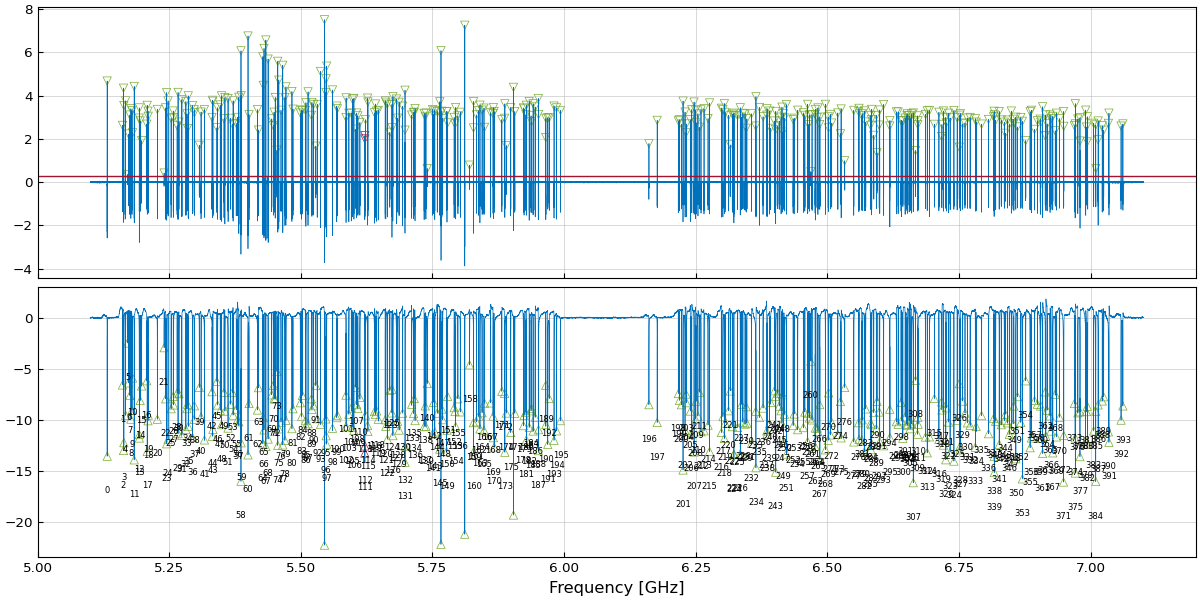

In [116]:
sw = 5 # even number
orders = 3
mph = .3
min_df = .1
window = np.ones(sw)/sw
smooth_s21 = savgol_filter(dark_s21, sw, orders)
ds21 = np.diff(smooth_s21, 1)
smooth_ds21 = savgol_filter(ds21, sw, orders)
d2s21 = np.diff(smooth_ds21, 1)

locs, props = find_peaks(d2s21, height=mph, prominence=mph)
heights = props['peak_heights']
# locs[501] -= 2
# locs[841] -= 2
locs += 1
f0s = freqs[locs]

df0s = f0s[1:] - f0s[:-1]
df_mask = np.zeros(f0s.shape, dtype=bool)
too_close = df0s < min_df*1e-3
too_close_mask = np.hstack((False, too_close)) + np.hstack((too_close, False))


s21_mins = smooth_s21[locs]
fig, ax = plt.subplot_mosaic('a;b', sharex=True, figsize=(12, 6), constrained_layout=True)
ax['a'].plot(freqs[2:], d2s21, lw=.5)
ax['b'].plot(freqs, smooth_s21, lw=.5)
ax['a'].axhline(mph, c='r')

ax['a'].scatter(freqs[locs[~too_close_mask]], heights[~too_close_mask], marker='v', c='None', edgecolor='g')
ax['b'].scatter(f0s[~too_close_mask], s21_mins[~too_close_mask], marker='^', c='None', edgecolor='g')
ax['a'].scatter(freqs[locs[too_close_mask]], heights[too_close_mask], marker='v', c='None', edgecolor='r')
ax['b'].scatter(f0s[too_close_mask], s21_mins[too_close_mask], marker='^', c='None', edgecolor='r')
for i, loc in enumerate(locs):
    ax['b'].annotate(f'{i}', (f0s[i], s21_mins[i]-5), textcoords="offset points", xytext=(0,10), ha='center', fontsize=6)
ax['b'].set_xlabel('Frequency [GHz]')
print('Total: ', len(locs))
print('Sufficiently spaced with ', min_df , 'MHz: ', len(locs[~too_close_mask]))

nr_steps = len(files)
nr_kids = len(f0s)
sweeps = np.empty((nr_steps, len(freqs)))
smoothed_sweeps = np.empty((nr_steps, len(freqs)))
s21s = np.empty((nr_steps, nr_kids))
s21s[:] = np.nan
smooth_dark_s21 =  savgol_filter(dark_s21, sw, orders)
s0 = smooth_dark_s21[locs]
for i, file in enumerate(files):
    f, s21 = np.load(file)
    sweeps[i, :] = s21
    smooth_s21 = savgol_filter(s21, sw, orders)
    smoothed_sweeps[i, :] = smooth_s21
    s21s[i, :]  = smooth_s21[locs] - s0 

In [117]:
def add_kids(doubles):
    global pos, maxproms, secproms, f0s, s21s, locs  # Declare global variables
    for i, double in enumerate(doubles):
        idx = double[0]+i
        pos = np.insert(pos, idx, double[2])
        maxproms = np.insert(maxproms, idx, secproms[idx])
        secproms = np.insert(secproms, idx, maxproms[idx])
        f0s = np.insert(f0s, idx, f0s[idx])
        s21s = np.insert(s21s, idx, s21s[:, idx], axis=1)
        locs = np.insert(locs, idx, locs[idx])
        doubles[i][0] += i
    return doubles


def del_kids(ids, doubles):
    global pos, maxproms, secproms, f0s, s21s, locs  # Declare global variables
    ids = np.sort(ids)
    for i, id in enumerate(ids):
        idx = id-i
        pos = np.delete(pos, idx)
        maxproms = np.delete(maxproms, idx)
        secproms = np.delete(secproms, idx)
        f0s = np.delete(f0s, idx)
        s21s = np.delete(s21s, idx, axis=1)
        locs = np.delete(locs, idx)
        for i, double in enumerate(doubles):
            if idx < double[0]:
                doubles[i][0] -= 1
            elif idx == double[0]:
                del doubles[i]
    return doubles

Mean prominence:  6.793089042194508
total:  398
nr doubles:  4
ID: 94, secprom: 8.7, at: 0
ID: 148, secprom: 8.1, at: 17
ID: 179, secprom: 3.7, at: 3
ID: 310, secprom: 3.6, at: 0


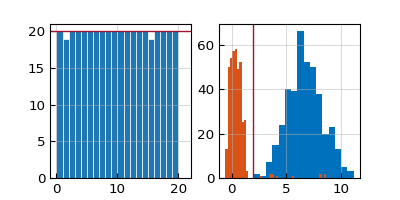

In [118]:

pos = np.empty((nr_kids)) # f0, 
pos[:] = np.nan
maxproms = np.empty((nr_kids)) # f0, 
maxproms[:] = np.nan
secproms = np.empty((nr_kids)) # f0, 
secproms[:] = np.nan
mpp = 2
doubles = []
shifted = []
df = 3e-4
for i in range(nr_kids):
    s21 = s21s[:, i]
    y = medfilt(s21, 3)
    x = np.arange(len(y))
    a, b = np.polyfit(x, y, 1)
    s21 -= (a*x + b)
    s21s[:, i] = s21
    baseline = medfilt(s21, 3)
    argsort = np.argsort(s21)
    argmax = argsort[-1]
    sec_id = -2
    secargmax = argsort[sec_id]
    while np.abs(secargmax - argmax) == 1:
        sec_id -= 1
        secargmax = argsort[sec_id]
    argmin = argsort[0]
    max = s21[argmax]
    secmax = s21[secargmax]
    min = s21[argmin]
    mean = np.mean(baseline)
    maxprom = max - mean
    secprom =  secmax - mean
    minprom = min - mean
    pos[i] = argmax
    maxproms[i] = maxprom
    secproms[i] = secprom
    if secprom > mpp: 
        doubles.append([i, secprom, secargmax])

doubles = add_kids(doubles)
delete = [390, 160, 112]
doubles = del_kids(delete, doubles)
pos[12] = 7
# pos[889] = 1
# delete = [145, 333, 461, 641, 803, 828, 929, 1018]



print('Mean prominence: ', sum(maxproms)/nr_kids)
fig, ax = plt.subplot_mosaic('ab', figsize=(4,2))
hist = ax['a'].hist(pos, bins=np.arange(nr_steps+1), facecolor='tab:blue', edgecolor='w')
ax['b'].axvline(mpp, c='r')
ax['a'].axhline(M_pxs, c='r')
ax['b'].hist(maxproms, bins='auto')
ax['b'].hist(secproms, bins='auto')
print('total: ', np.sum(~np.isnan(pos)))
print('nr doubles: ', len(doubles))
for double in doubles:
    print('ID: %d, secprom: %.1f, at: %d' % (double[0], double[1], double[2]))
df0s = f0s[1:] - f0s[:-1]
df_mask = np.zeros(f0s.shape, dtype=bool)
too_close = df0s < min_df*1e-3
too_close_mask = np.hstack((False, too_close)) + np.hstack((too_close, False))

Doubles: [20(17), 245, 691, 732, 992]
No resp : [26, 246] 


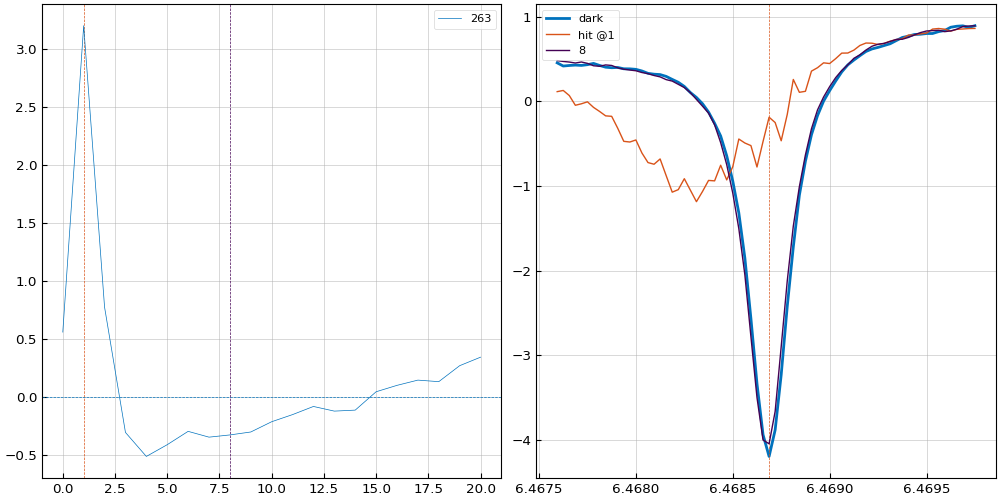

In [140]:
ids = [263]
fig, ax = plt.subplot_mosaic('ba', figsize=(10,5), constrained_layout=True)
start = 0
stop = 20

steps = [8]
bw =  35
colors = plt.cm.viridis(np.linspace(0, 1, len(steps)+1))

for id in ids:
    s21 = s21s[:, id]
    baseline = medfilt(s21, 3)
    res = f0s[id]
    loc = locs[id]
    hit = int(pos[id])
    ax['a'].plot(freqs[loc-bw:loc+bw], smooth_dark_s21[loc-bw:loc+bw], lw=2, label='dark')
    ax['a'].axvline(res, c='o', ls='--', lw=.5)
    ax['a'].plot(freqs[loc-bw:loc+bw], smoothed_sweeps[hit, loc-bw:loc+bw], lw=1, label='hit @' + str(hit), c='o')
    ax['b'].axvline(hit, ls='--', lw=.5, c='o')
    ax['b'].axhline(np.mean(baseline), ls='--', lw=.5, c='b')
    for i, step in enumerate(steps):
        ax['a'].plot(freqs[loc-bw:loc+bw], smoothed_sweeps[step, loc-bw:loc+bw], lw=1, label=str(step), c=colors[i])
        ax['b'].axvline(step, ls='--', lw=.5, c=colors[i])
    ax['b'].plot(s21, lw=.5, label=str(id), c='b')
ax['b'].legend()
ax['a'].legend()

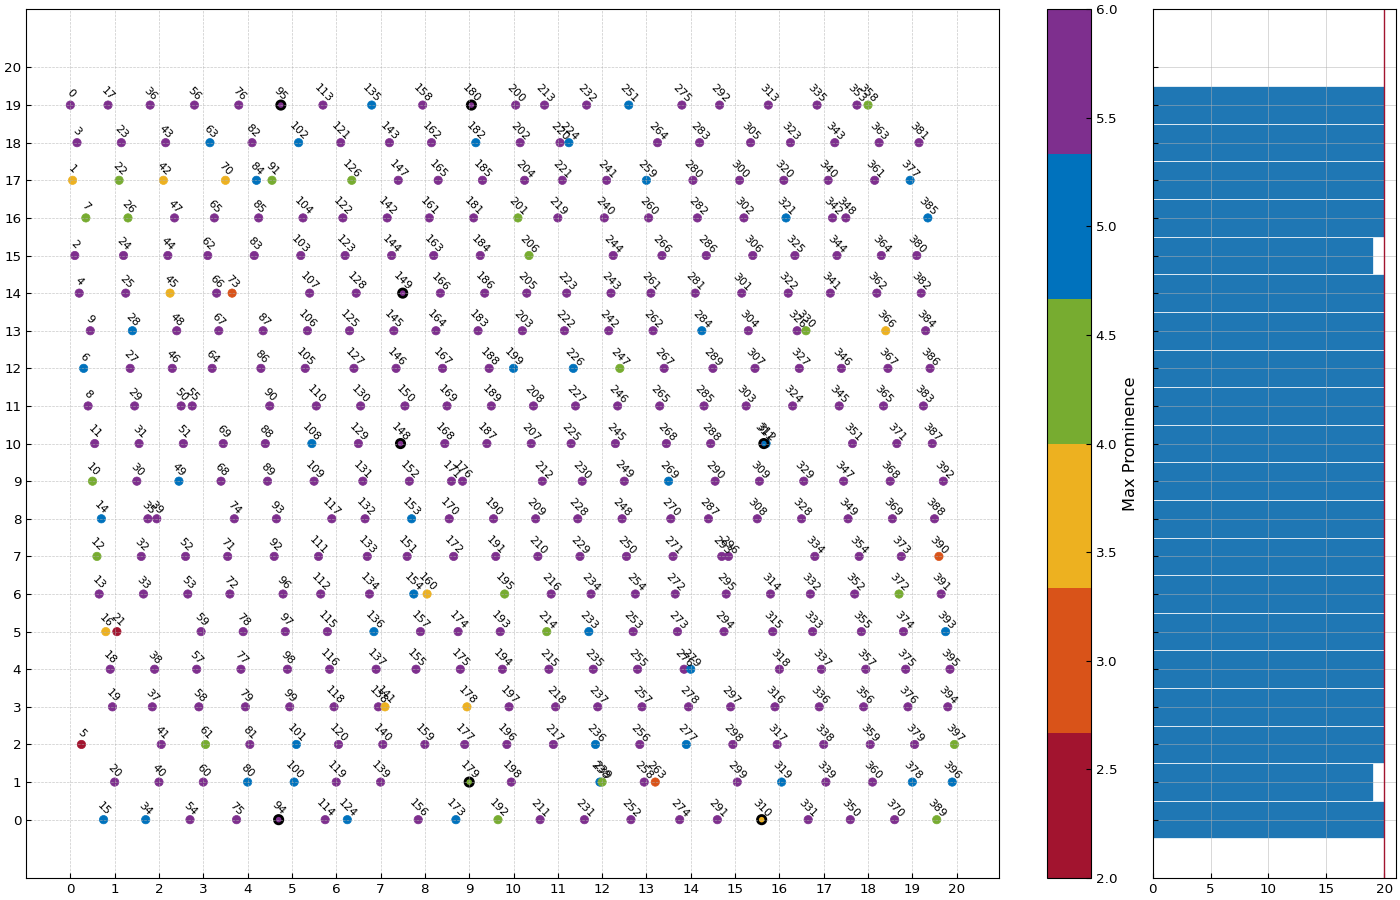

In [120]:
fig, ax = plt.subplot_mosaic('aaaab', figsize=(14,9), constrained_layout=True, sharey=True)   
x = np.rint(np.arange(len(pos))*nr/len(pos))/M_pxs
# ax['a'].scatter(x, pos, c=maxproms, cmap='tab10', vmin=mpp, vmax=3*mpp)
custom_colors = ['r', 'o', 'y', 'g', 'b', 'p']
custom_cmap = mpl.colors.ListedColormap(custom_colors)
ax['a'].scatter(x, pos, c=maxproms, cmap=custom_cmap, vmin=mpp, vmax=3*mpp)
cbar = fig.colorbar(ax['a'].collections[0], ax=ax['a'], orientation='vertical')
cbar.set_label('Max Prominence')
for id, row in enumerate(pos):
    ax['a'].annotate(id, (x[id], row+.3), fontsize=8, ha='center', va='center', rotation=-45)
for id, secprom, secargmax in doubles:
    ax['a'].scatter(x[id], pos[id], marker='o', facecolor='None', edgecolor='k', linewidth=2)
    ax['a'].scatter(x[id+1], pos[id+1], marker='o', facecolor='None', edgecolor='k', linewidth=2)
ax['a'].set_xticks(np.arange(0, M_pxs+1, 1))
ax['a'].set_yticks(np.arange(0, M_pxs+1, 1))
hist = ax['a'].grid(True, which='both', linestyle='--', lw=.5)
ax['b'].hist(pos, bins=np.arange(nr_steps+1)-.5, facecolor='tab:blue', edgecolor='w', orientation='horizontal')
ax['b'].axvline(M_pxs, c='r')
# ax['b'].set_xlim([M_pxs-4, M_pxs+3])

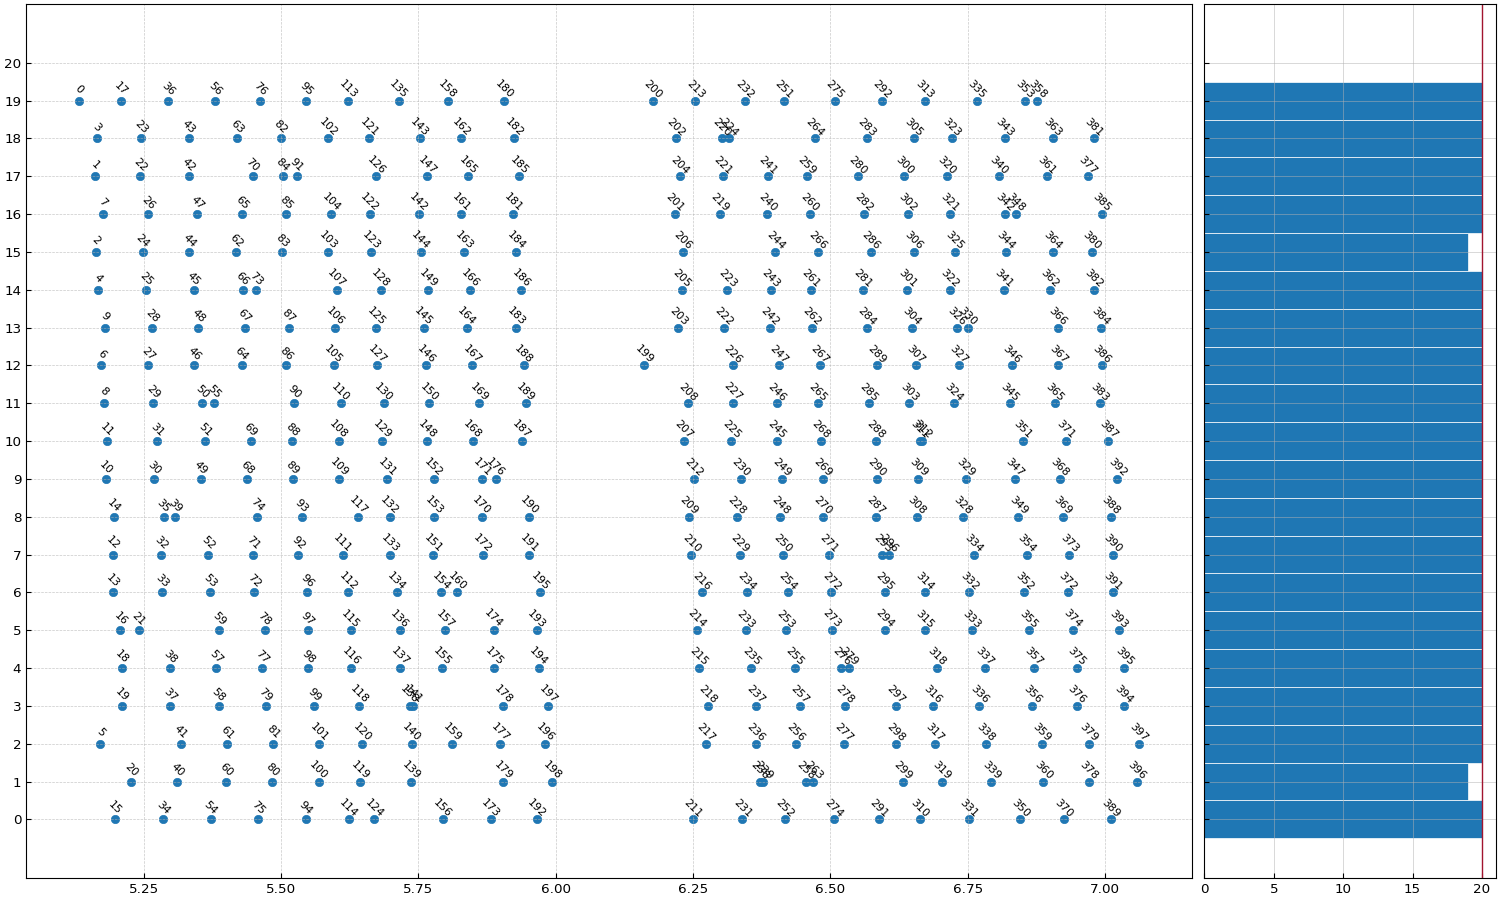

In [121]:
fig, ax = plt.subplot_mosaic('aaaab', figsize=(15,9), constrained_layout=True, sharey=True)   
x = np.rint(np.arange(len(pos))*nr/len(pos))/M_pxs
ax['a'].scatter(f0s, pos, c='tab:blue')
for id, row in enumerate(pos):
    ax['a'].annotate(id, (f0s[id], row+.3), fontsize=8, ha='center', va='center', rotation=-45)
hist = ax['a'].grid(True, which='both', linestyle='--', lw=.5)
ax['b'].hist(pos, bins=np.arange(nr_steps+1)-.5, facecolor='tab:blue', edgecolor='w', orientation='horizontal')
ax['b'].axvline(M_pxs, c='r')
_ = ax['a'].set_yticks(np.arange(0, M_pxs+1, 1))

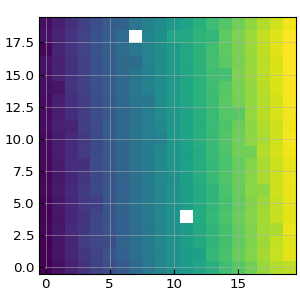

In [132]:
rows = [[] for _ in range(M_pxs)]
for id, row in enumerate(pos):
    if not np.isnan(row):
        rows[int(row)].append(int(id))
kids_derolled = np.empty((M_pxs, N_pxs))
kids_derolled[:] = np.nan   
for i, row in enumerate(rows):
    kids_derolled[i, :len(row)] = row
nans = [[1, 7], [15, 11]]
for i, j in nans:
    kids_derolled[i, j+1:] = kids_derolled[i, j:-1]
    kids_derolled[i, j] = np.nan
kids_derolled = np.flip(kids_derolled, axis=0)
fig, ax = plt.subplot_mosaic('a', figsize=(3,3), constrained_layout=True, sharey=True)   
ax['a'].imshow(kids_derolled, cmap='viridis', origin='lower')

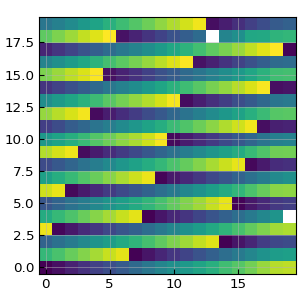

In [133]:
kids = copy(kids_derolled)
for i, row in enumerate(kids_derolled):
    kids[i] = np.roll(row, i*7)

fig, ax = plt.subplot_mosaic('a', figsize=(3,3), constrained_layout=True, sharey=True)   
ax['a'].imshow(kids, cmap='viridis', origin='lower')

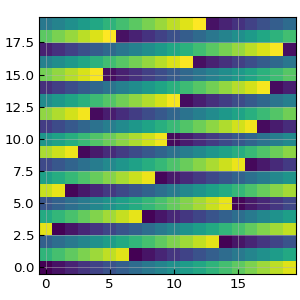

In [134]:
finger_lengths = main['design']['fingers']
design_f0s = main['design']['f0']
coupler_lengths = main['design']['couplers']
fig, ax = plt.subplot_mosaic('a', figsize=(3,3), constrained_layout=True, sharey=True)   
ax['a'].imshow(kid_id_board, cmap='viridis', origin='lower')

In [135]:
main['design']['row'] = np.empty(M_pxs*N_pxs)
main['design']['row'][:] = np.nan
main['design']['col'] = np.empty(M_pxs*N_pxs)
main['design']['col'][:] = np.nan
main['measured'] = {}
main['measured']['f0'] = np.empty(M_pxs*N_pxs)
main['measured']['f0'][:] = np.nan
for i, row in enumerate(kid_id_board):
    for j, idx in enumerate(row):
        main['design']['row'][idx] = i
        main['design']['col'][idx] = j
        meas_idx = kids[i, j]
        if ~np.isnan(meas_idx):
            meas_f = f0s[int(meas_idx)]
            main['measured']['f0'][idx] = meas_f
design = main['design']['f0']
meas = main['measured']['f0']
nanmask = np.isnan(meas)
sort_idx = np.argsort(meas[~nanmask])
inverse_sort_idx = np.argsort(sort_idx)

line
0.0029909831832295765


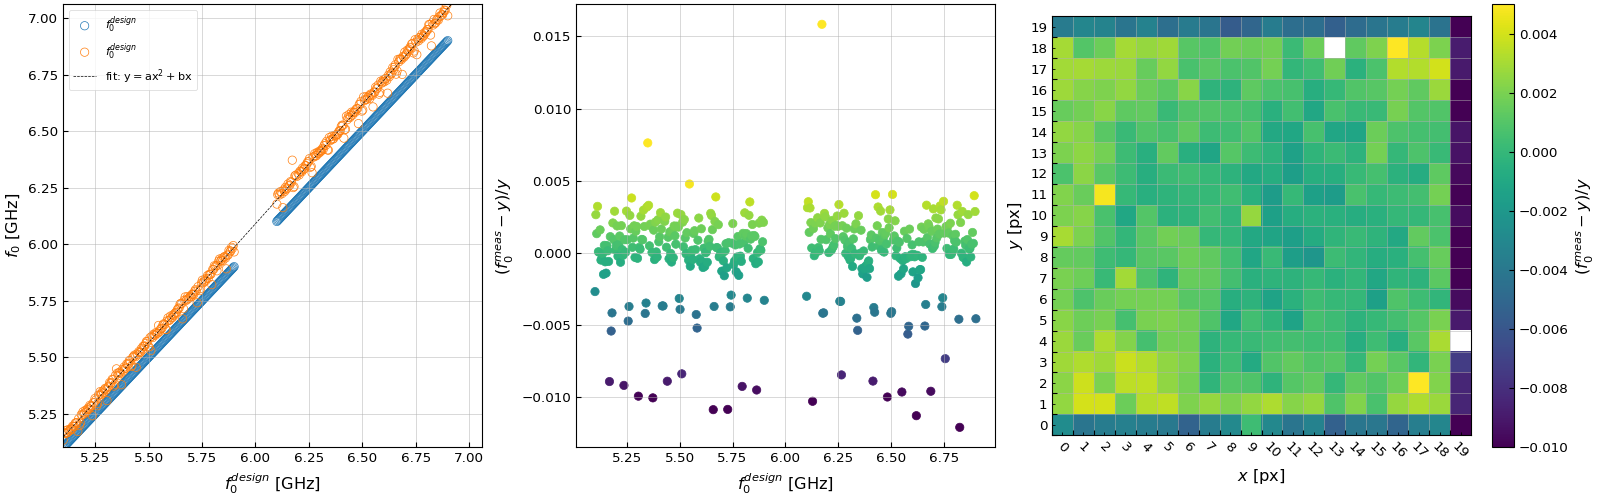

In [137]:
def linear(x, a, b):
    return a*x+b

def secorder(x, a, b, c):
    return a*x**2+b*x + c

line = secorder
size=M_pxs
if line:
    if line == linear:
        eq = 'y=ax'
        save = 'fit_linear'
    elif line == secorder:
        eq = 'y=ax^2+bx'
        save = 'fit_secorder'
    print('line')
    popt, pcov = curve_fit(line, design[~nanmask], meas[~nanmask])
    design_fit = line(design, *popt)
    # fit = line(design, *popt)
    flim = np.array([np.nanmin((design, meas)), np.nanmax((design, meas))])
    xfit = np.linspace(flim[0], flim[1])
    yfit = line(xfit, *popt)
    label = 'y'
else:
    design_fit = design
    label = 'f_0^{design}'
    save = 'nofit'
# popt, pcov = curve_fit(line, design[~nanmask], meas[~nanmask])
# design_fit = line(design, *popt)
df_f_fit = (meas - design_fit) / design_fit
df_f_map = df_f_fit[kid_id_board]


fig, ax = plt.subplot_mosaic('abc', figsize=(16, 5), constrained_layout=True)
ax['a'].scatter(design, design, c='None', edgecolor='tab:blue', label='$\it f_0^{design}$')
ax['a'].scatter(design, meas, c='None', edgecolor='tab:orange', label='$\it f_0^{design}$')
if line:
    ax['a'].plot(xfit, yfit, c='k', label='fit: $%s$' % eq, ls='--', lw=0.5)
ax['a'].set_xlabel('$\it f_0^{design}$ $[GHz]$')
ax['a'].set_ylabel('$\it f_0$ $[GHz]$')
ax['a'].set_xlim(flim)
ax['a'].set_ylim(flim)
ax['a'].legend(loc='upper left')
clim = [-0.01, 0.005]
ax['b'].scatter(design, df_f_fit, c=df_f_fit, vmin=clim[0], vmax=clim[1], label='residual, $f_0-y_2$')
# for i, x in enumerate(design):
#     ax['b'].annotate(i, (x, df_f_corr[i]), fontsize=8, ha='center', va='center')
ax['b'].annotate
ax['b'].set_ylabel('$\it (f_0^{meas}-%s)/%s$' % (label, label))
ax['b'].set_xlabel('$\it f_0^{design}$ $[GHz]$')
im = ax['c'].imshow(df_f_map, cmap='viridis', origin='lower', vmin=clim[0], vmax=clim[1])
for i, x in enumerate(df_f_map):
    for j, y in enumerate(x):
        if ~np.isnan(y):
            old_id = kid_id_board[i, j]
            new_id = kids[i, j]
            if old_id == new_id:
                c = 'w'
            else:
                c = 'r'
            # ax['c'].text(j, i, '%d' % new_id, ha='center', va='center', fontsize=7, color=c)
# Major ticks
ax['c'].set_xticks(np.arange(0, size, 1)-0.5, minor=False)
ax['c'].set_yticks(np.arange(0, size, 1)-0.5, minor=False)
ax['c'].set_xticks(np.arange(0, size, 1), minor=True)
ax['c'].set_yticks(np.arange(0, size, 1), minor=True)
# Labels for major ticks
ax['c'].set_xticklabels(np.arange(0, size, 1), minor=True, rotation=-45)
ax['c'].set_yticklabels(np.arange(0, size, 1), minor=True, rotation=0)
ax['c'].set_yticklabels([], minor=False)
ax['c'].set_xticklabels([], minor=False)
ax['c'].grid(which='major', linestyle='-', linewidth=0.5)
ax['c'].grid(which='minor', visible=False)

# labels
ax['c'].set_xlabel('$\it x$ $[px]$')
ax['c'].set_ylabel('$\it y$ $[px]$')
cbar = fig.colorbar(im, ax=ax['c'])
_ = cbar.ax.set_ylabel('$\it (f_0^{meas}-%s)/%s$' % (label, label))
print(np.std(df_f_fit[~nanmask]))


In [46]:
nr_scans = s21s.shape[0]

def map():
    maps = np.zeros((M_pxs, N_pxs, nr_scans))
    for nr in range(nr_scans):
        for i, m in enumerate(kids):
            for j, k in enumerate(m):
                if ~np.isnan(k):
                    k = int(k)
                    s21s[:, k] -= np.amin(s21s[:, k])
                    s21s[:, k] /= np.amax(s21s[:, k])
                    maps[i, j, nr] = s21s[nr, int(k)]
                else:
                    maps[i, j, nr] = np.nan

    return maps

maps = map()

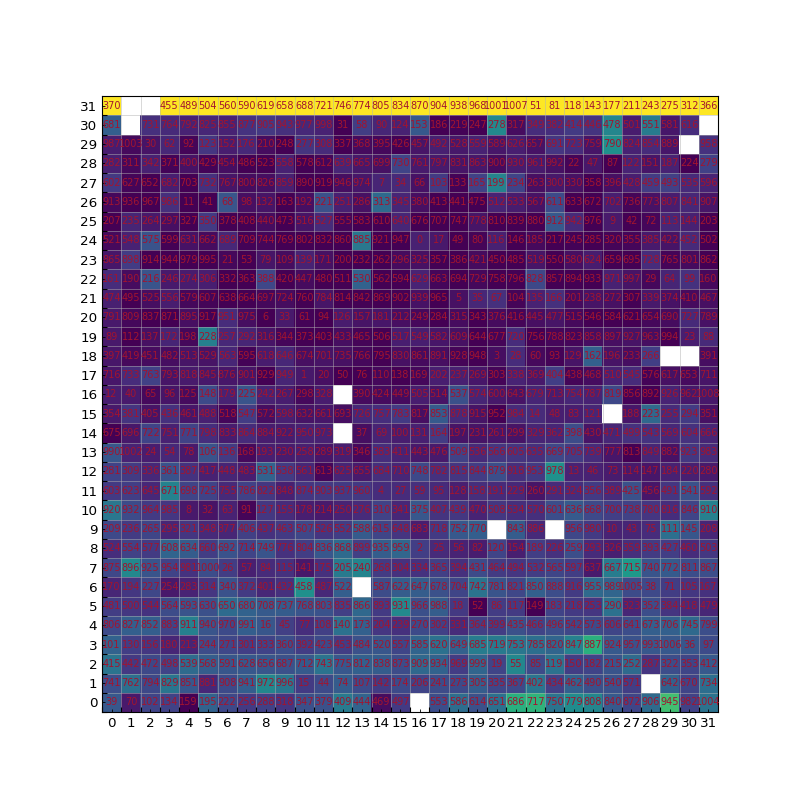

In [76]:
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(maps[:, :, 31], origin='lower', cmap='viridis')
for i, x in enumerate(df_f_map):
    for j, y in enumerate(x):
            if ~np.isnan(y):
                new_id = kids[i, j]
                ax.text(j, i, '%d' % new_id, ha='center', va='center', fontsize=7, color='r')
# Major ticks
ax.set_xticks(np.arange(0, size, 1)-0.5, minor=False)
ax.set_yticks(np.arange(0, size, 1)-0.5, minor=False)
ax.set_xticks(np.arange(0, size, 1), minor=True)
ax.set_yticks(np.arange(0, size, 1), minor=True)
# Labels for major ticks
ax.set_xticklabels(np.arange(0, size, 1), minor=True, rotation=0)
ax.set_yticklabels(np.arange(0, size, 1), minor=True, rotation=0)
ax.set_yticklabels([], minor=False)
ax.set_xticklabels([], minor=False)
ax.grid(which='major', linestyle='-', linewidth=0.5)
ax.grid(which='minor', visible=False)

In [ ]:
import matplotlib.animation as animation

fig, ax = plt.subplots(figsize=(8,8))
cax = ax.imshow(maps[:, :, 0], origin='lower', cmap='viridis')
for i, x in enumerate(df_f_map):
    for j, y in enumerate(x):
            if ~np.isnan(y):
                new_id = kids[i, j]
                ax.text(j, i, '%d' % new_id, ha='center', va='center', fontsize=7, color='r')
# Major ticks
ax.set_xticks(np.arange(0, size, 1)-0.5, minor=False)
ax.set_yticks(np.arange(0, size, 1)-0.5, minor=False)
ax.set_xticks(np.arange(0, size, 1), minor=True)
ax.set_yticks(np.arange(0, size, 1), minor=True)
# Labels for major ticks
ax.set_xticklabels(np.arange(0, size, 1), minor=True, rotation=-45)
ax.set_yticklabels(np.arange(0, size, 1), minor=True, rotation=0)
ax.set_yticklabels([], minor=False)
ax.set_xticklabels([], minor=False)
ax.grid(which='major', linestyle='-', linewidth=0.5)
ax.grid(which='minor', visible=False)

def update(frame):
    cax.set_array(maps[:, :, frame])
    return cax,
ani = animation.FuncAnimation(fig, update, frames=nr_scans, interval=200, blit=True)
plt.show()
# ani.save('LT402chip5_movie.gif', writer='Pillow')


In [256]:
def rel_freqs(f0, oct, Q, nr_kids):
    Q_spacing = Q*(2**(oct/nr_kids)-1)
    powers = np.arange(nr_kids)
    f0s = f0 * (1+Q_spacing/Q)**powers
    return f0s

def rel_freqs(f0, f1, nr_kids):
    oct = np.log2(f1/f0)
    spacing = 2**(oct/(nr_kids-1))
    powers = np.arange(nr_kids)
    f0s = f0 * (spacing)**powers
    return f0s

def lin_freqs(f0, fN, nr_kids):
    return np.linspace(f0, fN, nr_kids, endpoint=True)

def line(x, a, b):
    return a*x+b


In [ ]:
fig, axes = plt.subplot_mosaic('a;b', figsize=(10, 5))
ax = axes['a']
sorted_fs = meas[~nanmask][sort_idx]
ids = np.arange(len(meas))[~nanmask]
nr_kids = len(sorted_fs)
nr_lower = 504
nr_upper = nr_kids - nr_lower
ax.scatter(ids, sorted_fs, label='measured (sorted)', c='b')
df = 0.01
lower_f0s = rel_freqs(sorted_fs[0]+0.062, sorted_fs[nr_lower-3]-0.009, nr_lower+1)-0.004
upper_f0s = rel_freqs(sorted_fs[nr_lower+1]+.13, sorted_fs[-1]+.001, nr_kids-(nr_lower+1))
lower_ids = ids[:nr_lower+1]
upper_ids = ids[nr_lower+1:]
ax.scatter(lower_ids, lower_f0s, c='o')
ax.scatter(upper_ids, upper_f0s, c='y')
ax = axes['b']
ax.scatter(lower_ids, sorted_fs[:nr_lower+1]-lower_f0s, c='o')
ax.scatter(upper_ids, sorted_fs[nr_lower+1:]-upper_f0s, c='y')
# ax.legend()

nibble_freqs = np.hstack((lower_f0s, upper_f0s))[inverse_sort_idx]
main['trimdesign'] = {}
main['trimdesign']['f0'] = np.empty(M_pxs*N_pxs)
main['trimdesign']['f0'][:] = np.nan
main['trimdesign']['f0'][~nanmask] = nibble_freqs

In [ ]:
fig, axes = plt.subplot_mosaic('a;b', figsize=(10, 5))
ax = axes['a']
sorted_fs = meas[~nanmask][sort_idx]
ids = np.arange(len(meas))[~nanmask]
nr_kids = len(sorted_fs)
nr_lower = 504
nr_upper = nr_kids - nr_lower
ax.scatter(ids, sorted_fs, label='measured (sorted)', c='b')
df = 0.01
lower_f0s = rel_freqs(sorted_fs[5]+0.001, sorted_fs[nr_lower]+0.005, nr_lower+1)
upper_f0s = rel_freqs(sorted_fs[nr_lower+10]+0.001, sorted_fs[-1]+.001, nr_kids-(nr_lower+1))
lower_ids = ids[:nr_lower+1]
upper_ids = ids[nr_lower+1:]
ax.scatter(lower_ids, lower_f0s, c='o')
ax.scatter(upper_ids, upper_f0s, c='y')
ax = axes['b']
ax.scatter(lower_ids, sorted_fs[:nr_lower+1]-lower_f0s, c='o')
ax.scatter(upper_ids, sorted_fs[nr_lower+1:]-upper_f0s, c='y')
# ax.legend()

nibble_freqs = np.hstack((lower_f0s, upper_f0s))[inverse_sort_idx]
main['trimdesign'] = {}
main['trimdesign']['f0'] = np.empty(M_pxs*N_pxs)
main['trimdesign']['f0'][:] = np.nan
main['trimdesign']['f0'][~nanmask] = nibble_freqs

In [ ]:
fingers = main['design']['fingers']
ids  = np.arange(nr)
trim_design = main['trimdesign']['f0']

fig, axes = plt.subplot_mosaic('aabbee;ccddee', figsize=(15,5), constrained_layout=True)
ax = axes['a']
ax.scatter(design, fingers, label='design f')
ax.scatter(meas, fingers, label='meas f')
ax.scatter(trim_design, fingers, label='nibble f')
ax.set_ylabel('finger length [um]')
ax.set_xlabel('frequency [GHz]')

def poly(x, a, b, c, d, e, f):
    return a*x**5 + b*x**4 + c*x**3+d*x**2+e*x+f

popt, pcov = curve_fit(poly, meas[~nanmask], fingers[~nanmask])
fit_fingers = poly(meas, *popt)   
ax.plot(meas, fit_fingers, c='k', lw=1)	
new_fingers = poly(trim_design, *popt)
nibble_fingers = new_fingers+(fingers-fit_fingers)
# trims = copy(meas)
trims = nibble_fingers - fingers
ax.scatter(trim_design, nibble_fingers, c='r', lw=1, label='nibble f+trim')
ax.legend()

ax = axes['b']
ax.scatter(ids, trims)
ax.set_xlabel('kids')
ax.set_ylabel('trim [um]')
ax.axhline(0, c='r')
print('minimum trim = %.3f um' % np.nanmax(trims[trims<0]))
print('maximum trim = %.3f um' % np.nanmin(trims))

ax = axes['c']
ax.scatter(design, design, label='original design')
ax.scatter(design, meas, label='measured')
ax.scatter(design, trim_design, label='nibble design')
ax.set_ylabel('freqency [GHz]')
ax.set_xlabel('design frequency [GHz]')
ax.legend()
ax = axes['d']
secax = ax.twinx()
df = (trim_design[~nanmask][sort_idx][1:]-trim_design[~nanmask][sort_idx][:-1])
df_f = df / trim_design[~nanmask][sort_idx][:-1]
lo = np.argmax(df)
lo_mask = np.ones(len(df), dtype=bool)
lo_mask[lo] = 0
ax.plot(df[lo_mask]*1e3, label='abs. spacing df')
secax.plot(df_f[lo_mask]*1e4, c='o', label='rel. spacing df/f')
ax.set_ylabel('df [MHz]')
secax.set_ylabel('df/f $\\times 10^4 $')
ax.set_xlabel('kids')
ax.legend()
secax.legend()
ax = axes['e']
ax.imshow(trims[kid_id_board], origin='lower')
invalid = trims > 0
main['trimdesign']['fingers'] = nibble_fingers
main['trimdesign']['f0'][invalid] = np.nan
main['trimdesign']['fingers'][invalid] = np.nan
print('Frequenty range: %.2f-%.2f GHz' % (np.nanmin(nibble_freqs), np.nanmax(nibble_freqs)))
print('LO gap: %d MHz at %.2f GHz' % (np.nanmax(df)*1e3, (nibble_freqs[np.argmax(df)]+nibble_freqs[np.argmax(df)+1])/2))
print('%d pixels lost at: ' % (np.sum(trims > 0)), np.argwhere(trims > 0))

In [ ]:
np.round(trims[kid_id_board][-1,-1]/2, 3)

In [410]:
np.save(path + chip + '_Lf_trim.npy', main['trimdesign']['fingers'])

In [ ]:
trims = (master_array[:, 3] - master_array[:, 8])[kid_id_board]
trims[-6,0]


In [34]:
trims = master_array[:, 3] - master_array[:, 8]
np.save('LT361_chip8_trims.npy', trims[kid_id_board])
np.save('LT361_chip8_new_fingers.npy', master_array[:, 8])
np.save('LT361_chip8_master.npy', master_array)

In [34]:
N_fingers = 13 # number of IDC fingers
nr_fingers_cut = 7
finger_length = 111.# full length of the fingers

In [ ]:
nr_fingers = 7
finger_length = 111
max_cut = 104
original_fingers= master_array[:, 3]
nibbled_fingers = master_array[:, 8]
original_cut = nr_fingers*finger_length - original_fingers
nibbled_cut = nr_fingers*finger_length - nibbled_fingers
nibble_two_fingers = ((original_cut // max_cut) != (nibbled_cut // max_cut)).astype(float)
nibble_two_fingers[nanmask] = np.nan
too_little_room_at_start_finger = (nibbled_cut % max_cut < np.nanmax(trims)).astype(float)
too_little_room_at_start_finger[nanmask] = np.nan
both = ((nibble_two_fingers==1)!=(too_little_room_at_start_finger==0))
fig, ax = plt.subplot_mosaic('ab', figsize=(8,4))
ax['a'].imshow((too_little_room_at_start_finger)[kid_id_board], origin='lower')
ax['b'].imshow((nibble_two_fingers)[kid_id_board], origin='lower')

In [ ]:
kid = kid_id_board[31,0]
print('old finger cut: ', 777-original_fingers[kid], (777-original_fingers[kid])//max_cut, ' fingers', (777-original_fingers[kid])%max_cut, ' rem')
print('new finger cut: ', 777-nibbled_fingers[kid],(777-nibbled_fingers[kid])//max_cut, ' fingers', (777-nibbled_fingers[kid])%max_cut, ' rem')
print('trimmed length: ', trims[kid])

In [ ]:
nibbled_fingers[too_little_room_at_start_finger.astype(bool)]

In [ ]:
old = master_array[:, 3]
new = master_array[:, 8]
nr_fingers = 7
finger_length = 111
max_cut = 104
trim_width = 4.5
min_trim = 13

for i, nl in enumerate(new):
    if np.isnan(nl):
        nl = nr_fingers*max_cut
    ol = old[i]
    of = ol // max_cut
    nf = nl // max_cut
    rem = nl - nf*max_cut
    if of != nf:
        print('two')
        # place symbol min_trim (x=of, y=max_cut-trim_min)
    if rem < min_trim:
        print(rem)
        # make symbol rem
        # place symbol rem+dy (x=nf, y=-dy)
    else:
        print(rem)
        # place symbol min_trim (x=nf, y=rem-min_trim)
        


    